In [1]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=7d468d38950e48045161f95947555b3fd6f285141cde5c410a9b595046fc0239
  Stored in directory: /home/jovyan/.cache/pip/wheels/e2/62/1e/926d1ebe7b1e733c78d627fd288d01b83feaf67efc06e0e4c3
Successfully built gdown
     |████████████████████████████████| 394.4 MB 7.4 kB/s eta 0:00:01   |                                | 665 kB 3.3 MB/s eta 0:01:59     |▎                               | 2.8 MB 3.3 MB/s eta 0:01:59     |▌                               | 6.8 MB 3.5 MB/s eta 0:01:52     |▊                               | 9.2 MB 4.0 MB/s eta 0:01:36     |█                               | 12.0 MB 3.5 MB/s eta 0:01:51     |█▌                              | 18.9 MB 3.7 MB/s eta 0:01:41     |█▌                              | 19.0 MB 3.7 MB/s eta 0:01:41     |████                            | 50.1 MB 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv(
  "/home/jovyan/work/training_data/sw_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/training_data/sw_training_data.csv'

In [ ]:
df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [ ]:
df.shape

In [6]:
df.head()

,sl_read1,bl_ahd1,mean_temp1,bl_ahd2,mean_temp2,rf_read1
read_date,,,,,,
2005-12-02,0.295,253.271,19.800,251.641,21.400,19.8
2005-12-03,0.303,253.277,19.825,251.644,21.350,21.4
2005-12-04,0.307,253.278,19.800,251.639,21.375,0.0
2005-12-05,0.303,253.275,19.824,251.636,21.375,0.0
2005-12-06,0.304,253.273,19.801,251.638,21.400,0.0


In [6]:
#df['hour'] = df.index.hour
#df['day_of_month'] = df.index.day
#df['day_of_week'] = df.index.dayofweek
#df['month'] = df.index.month

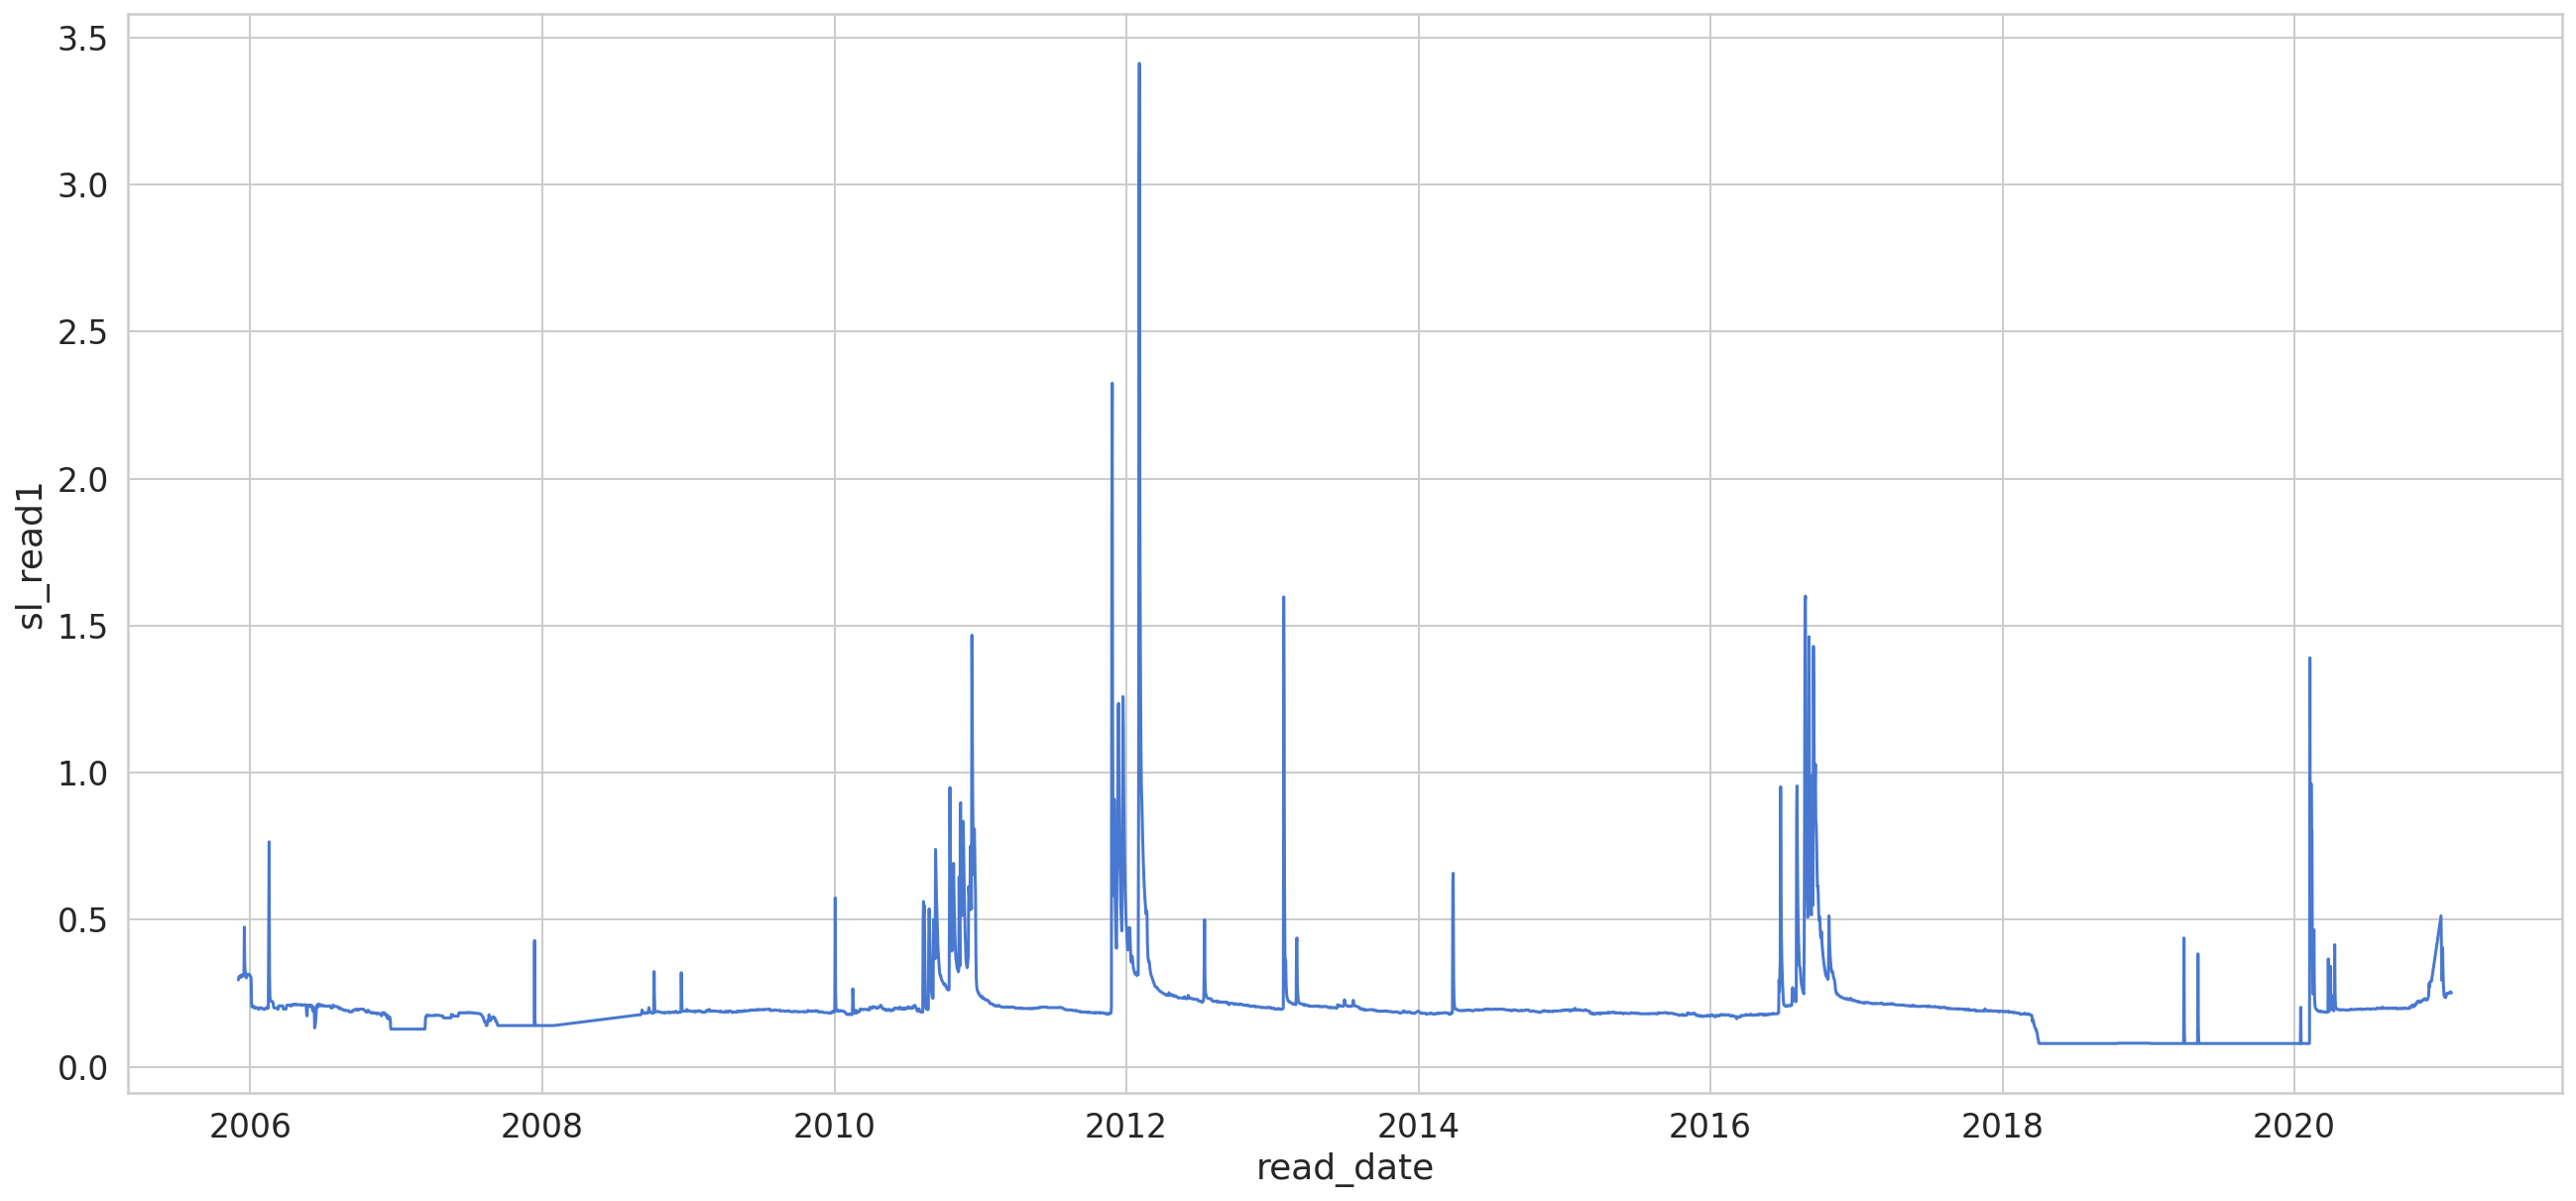

In [7]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

In [8]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
#df_test=test.copy()
print(len(train), len(test))

3972 1325


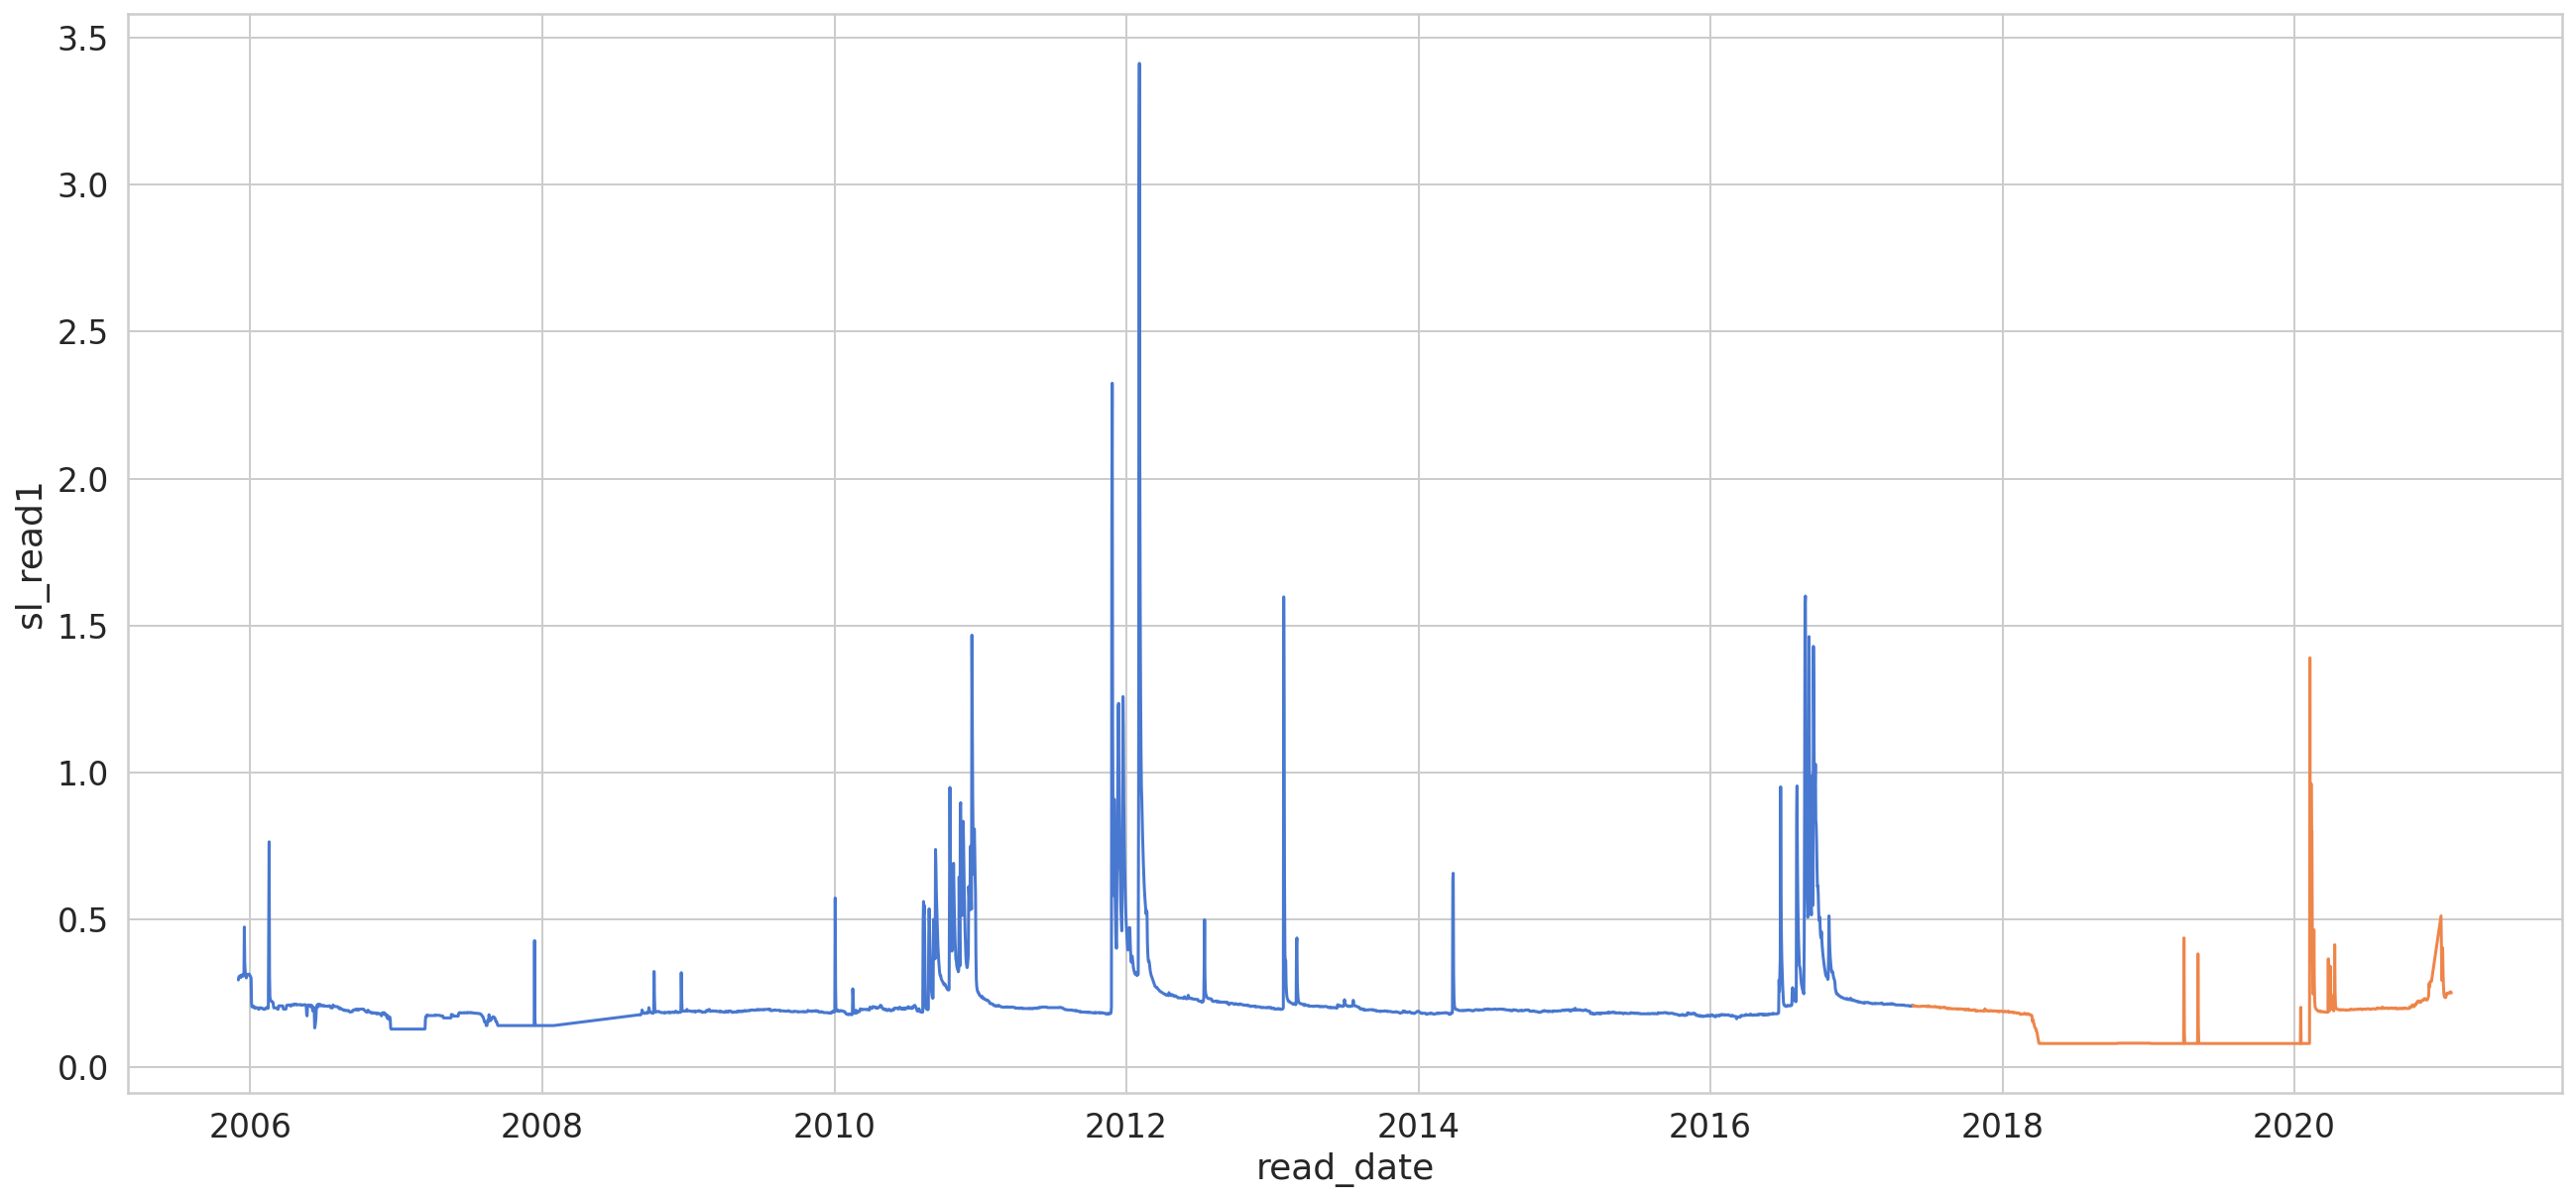

In [9]:
sns.lineplot(x=train.index, y="sl_read1", data=train);
sns.lineplot(x=test.index, y="sl_read1", data=test);

In [10]:
from sklearn.preprocessing import RobustScaler


rf_columns = ['mean_temp1','mean_temp2','rf_read1']
sl_columns = ['bl_ahd1', 'bl_ahd2','sl_read1']

rf_transformer = RobustScaler()
sl_transformer = RobustScaler()

rf_transformer = rf_transformer.fit(train[rf_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[sl_columns].to_numpy())

train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
train.loc[:, sl_columns] = sl_transformer.transform(train[sl_columns].to_numpy())

test.loc[:, rf_columns] = rf_transformer.transform(test[rf_columns].to_numpy())
test.loc[:, sl_columns] = sl_transformer.transform(test[sl_columns].to_numpy())



# f_transformer = f_transformer.fit(train[f_columns].to_numpy())
# sl_transformer = sl_transformer.fit(train[y_columns].to_numpy())
# 
# 
# 
# train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
# train.loc[:, y_columns] = sl_transformer.transform(train[y_columns].to_numpy())
# 
# test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
# test.loc[:, y_columns] = sl_transformer.transform(train[y_columns].to_numpy())


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-8be39b4a597e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc

In [11]:
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

#    for i in range(len(X) - time_steps):
#        d = i + time_steps
#        
#        Xs.append(X[i:d,])
#        Ys.append(y[d])
        
    
    return np.array(Xs), np.array(ys)

In [12]:
time_steps = 60


# reshape to [samples, time_steps, n_features]

# X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
# X_test, y_test = create_dataset(test, test.sl_read1, time_steps)

X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
X_test, y_test = create_dataset(test,test.sl_read1, time_steps)

# print(X_train)
# print(y_train)

print(X_train.shape, y_train.shape)

(3962, 10, 6) (3962,)


In [13]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
112/112 [==============================] - 5s 21ms/step - loss: 16.0324 - val_loss: 44.9134
Epoch 2/30
112/112 [==============================] - 2s 14ms/step - loss: 11.9630 - val_loss: 35.3270
Epoch 3/30
112/112 [==============================] - 1s 13ms/step - loss: 10.3735 - val_loss: 34.4384
Epoch 4/30
112/112 [==============================] - 1s 12ms/step - loss: 9.9975 - val_loss: 31.0395
Epoch 5/30
112/112 [==============================] - 1s 13ms/step - loss: 9.2249 - val_loss: 27.0581
Epoch 6/30
112/112 [==============================] - 1s 13ms/step - loss: 8.6462 - val_loss: 24.9869
Epoch 7/30
112/112 [==============================] - 1s 13ms/step - loss: 8.1754 - val_loss: 22.4212
Epoch 8/30
112/112 [==============================] - 2s 14ms/step - loss: 8.2657 - val_loss: 19.7282
Epoch 9/30
112/112 [==============================] - 1s 13ms/step - loss: 7.9132 - val_loss: 21.3581
Epoch 10/30
112/112 [==============================] - 1s 13ms/step - loss: 6.9

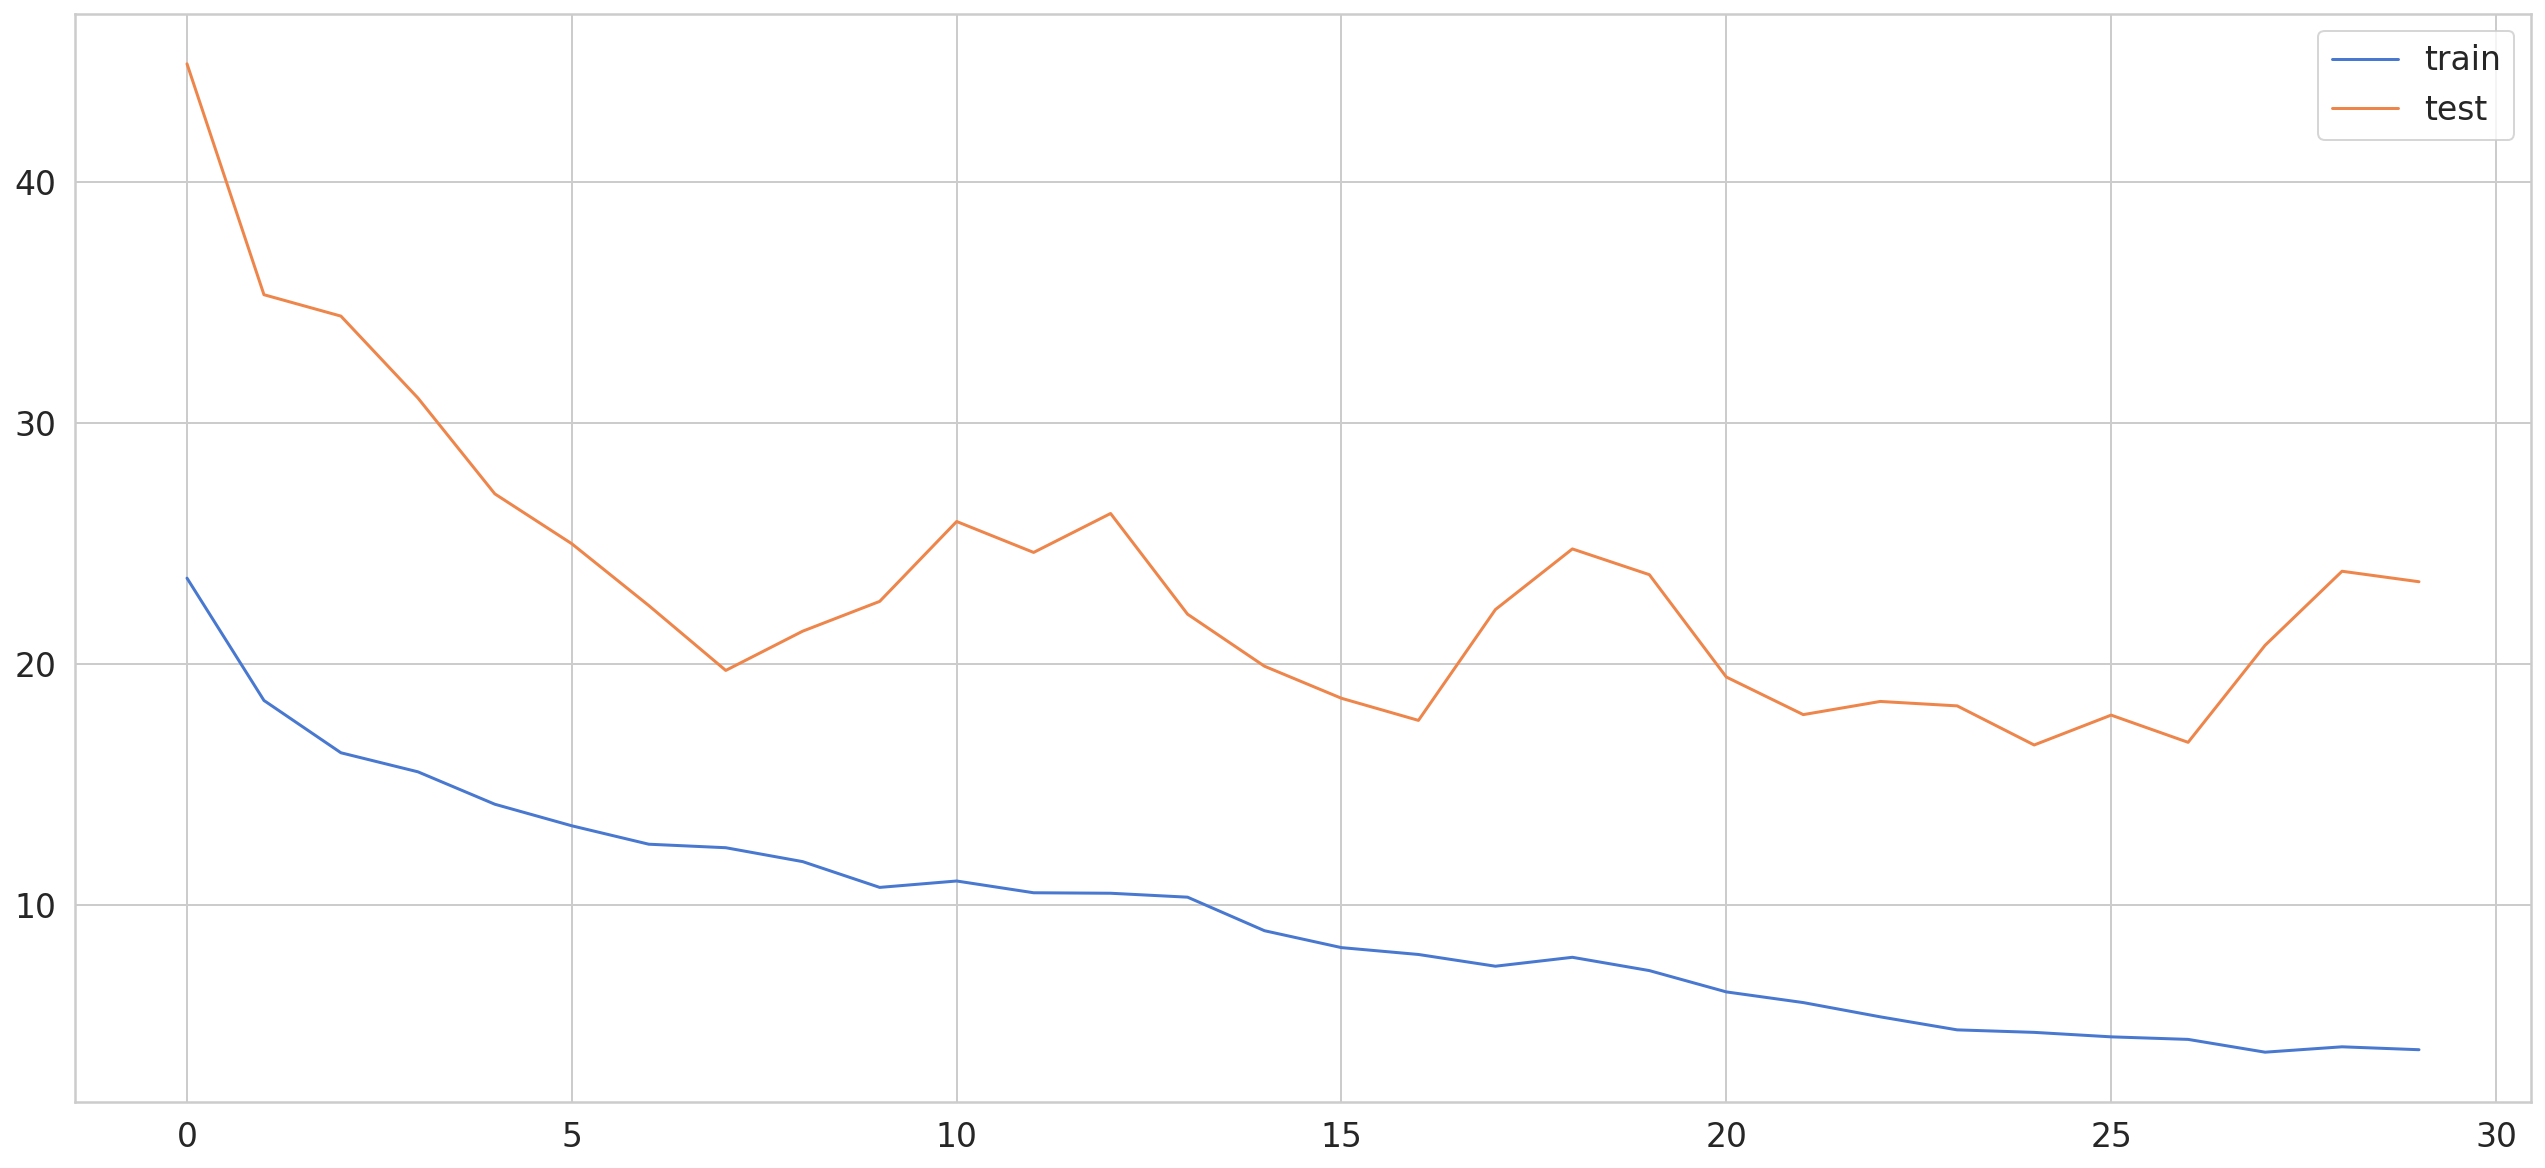

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [131]:
y_pred = model.predict(X_test)

In [132]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

ValueError: operands could not be broadcast together with shapes (1,3962) (3,) (1,3962) 

ValueError: x and y must have same first dimension, but have shapes (3945,) and (1315,)

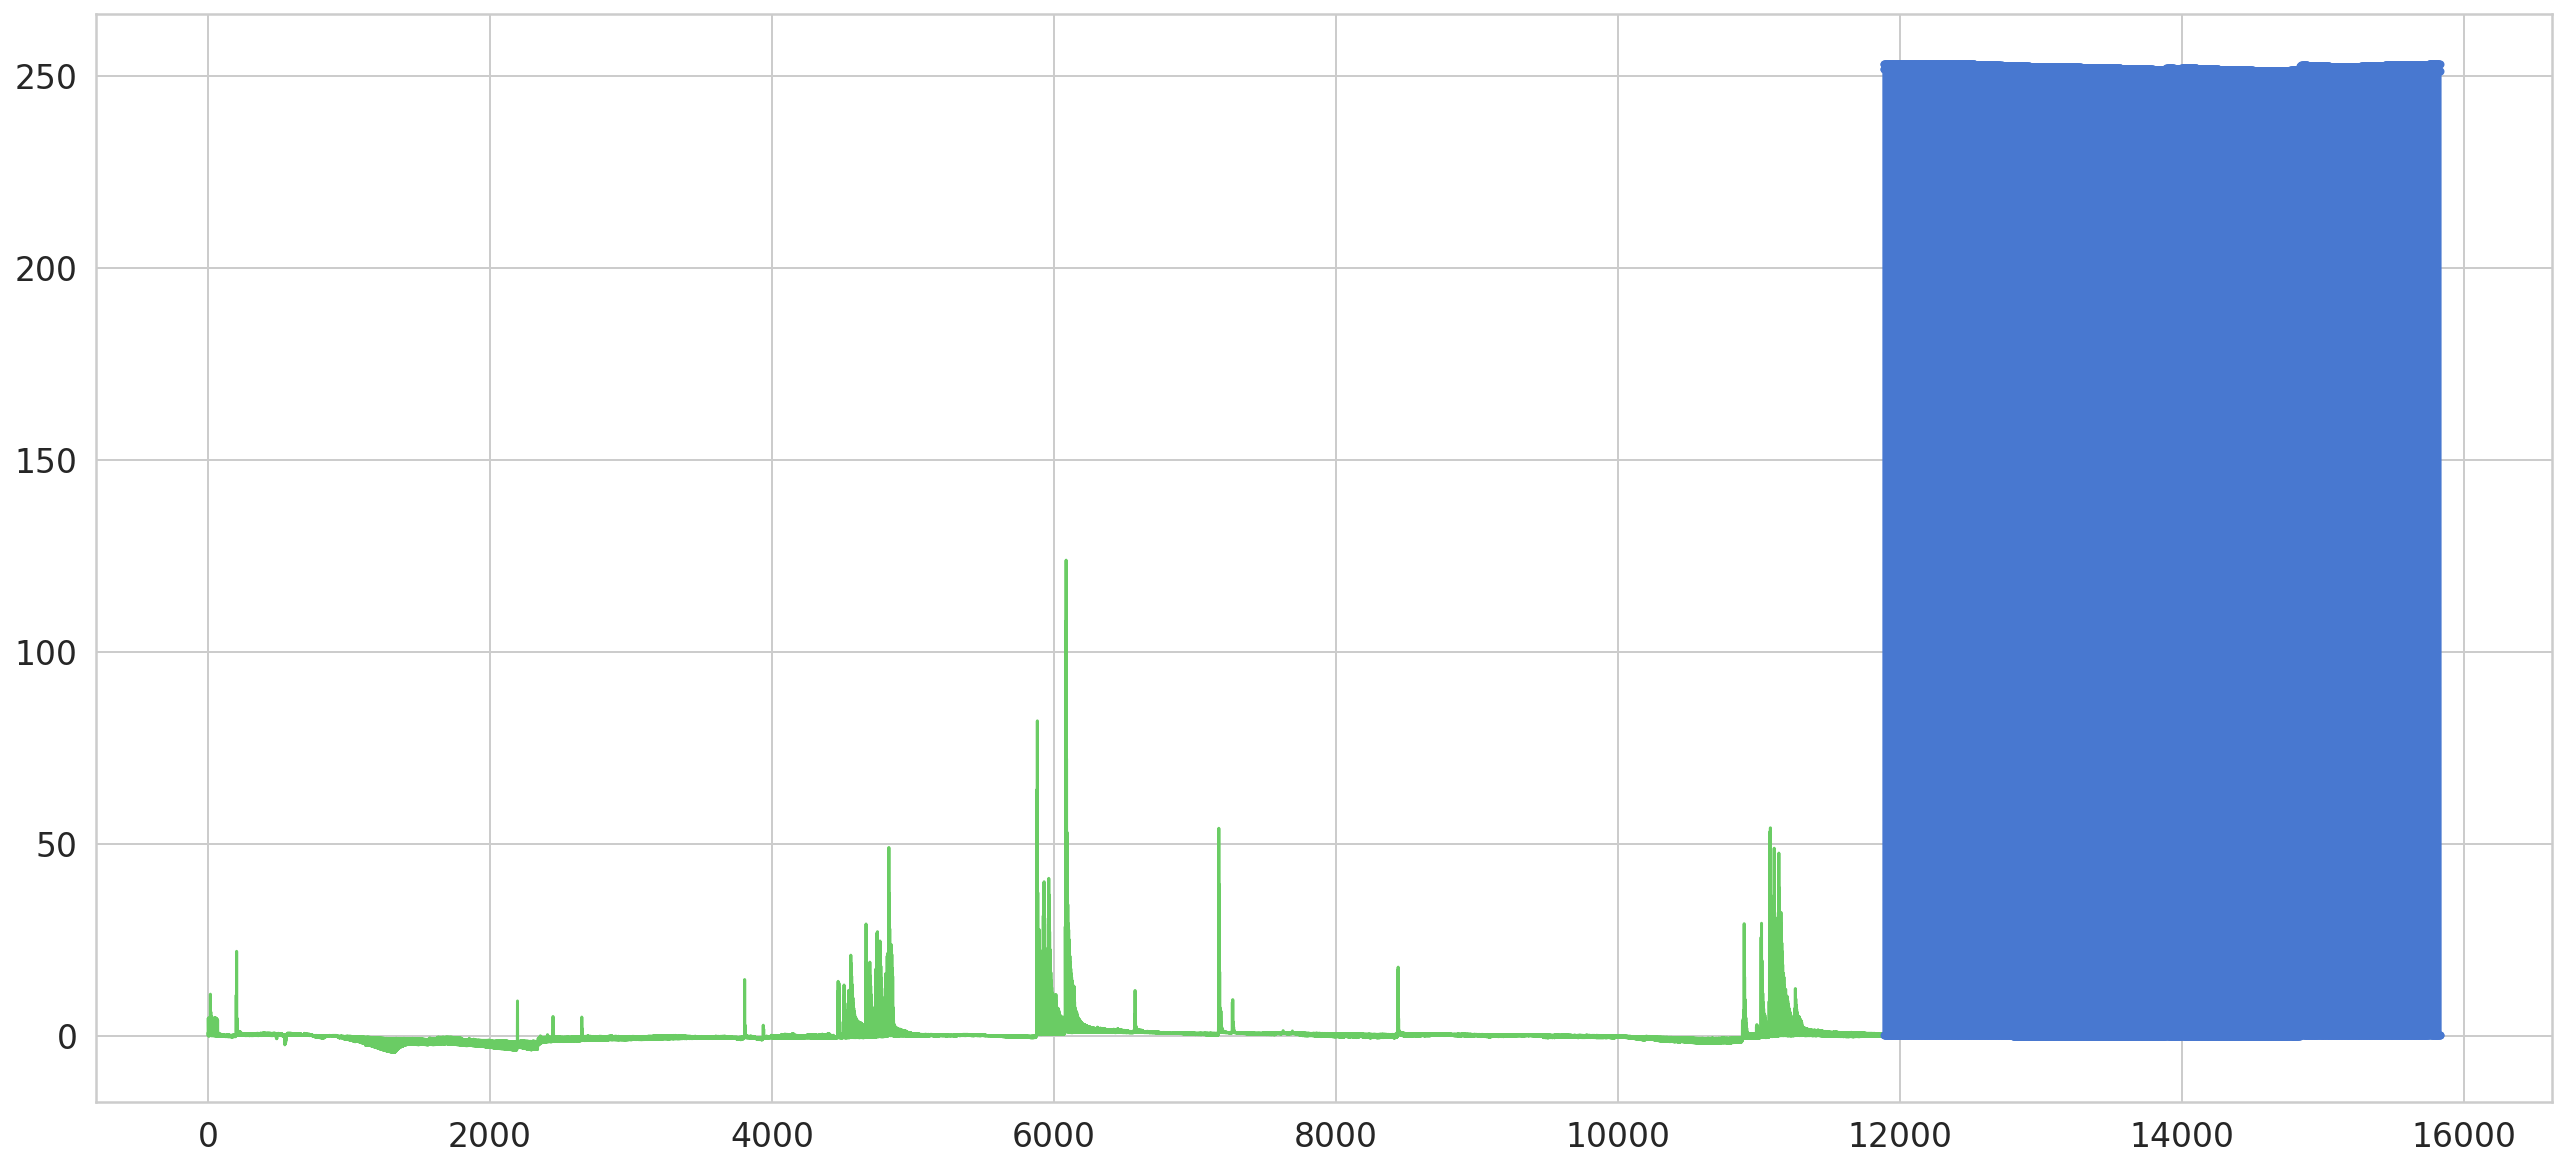

In [91]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

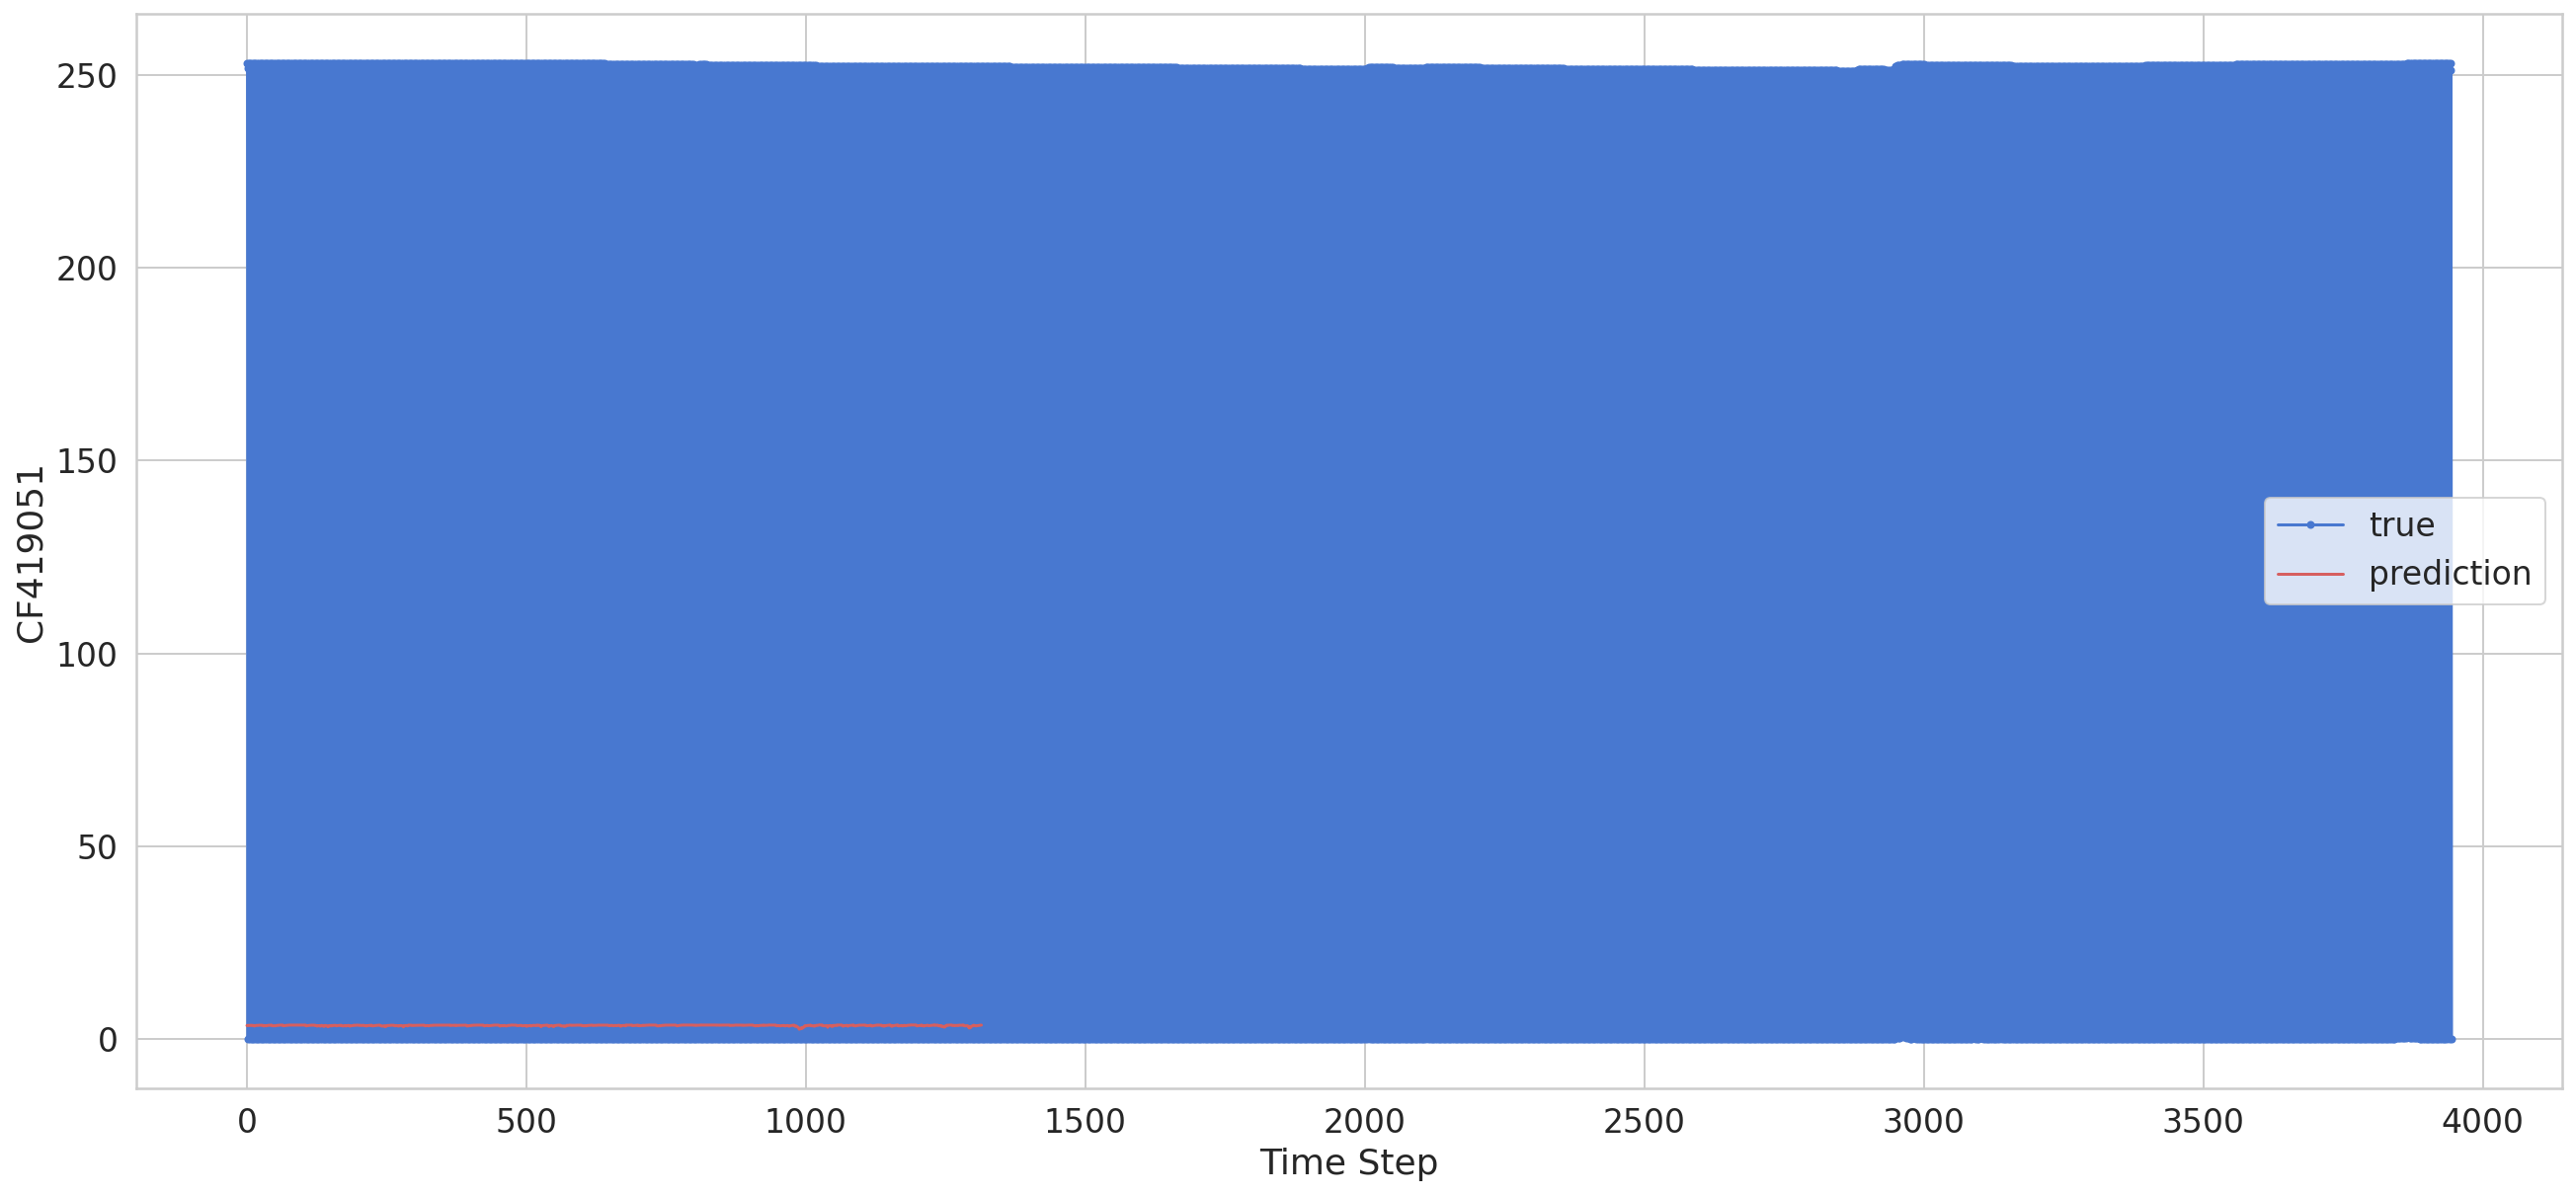

In [92]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [357]:
print(y_pred_inv)
#y_pred_inv.to_csv('/home/jovyan/work/predictions/sw_pred.csv', index=False)

[[0.18741971]
 [0.19367151]
 [0.19410387]
 ...
 [0.22151604]
 [0.22623481]
 [0.22691785]]


In [358]:
print(y_pred_inv.dtype)


df_test.cols['sl_pred'] = 0.0
df_test.insert(loc=len(df_test.columns),column='sl_pred', value=

print(df_test)

df_y_pred = pd.DataFrame(y_pred_inv)
#df_y_pred.insert(loc=0, column='read_date', value='2020-01-01')
#df_test = test_inv.copy()

for i in range(len(df_test)):
  
    if (i == time_steps):
        j = 0
        df_test.iloc[i,6] == df_y_pred.iloc[j,0]
        print('i: ',i, 'date: ', df_test.index[i], df_test.iloc[i,6])
    
        j = j + 1

    
print(df_y_pred)

#
sda
df_y_pred = pd.DataFrame(y_pred_inv)  #,index=None,dtype=float
df_y_pred.insert(loc=0, column='read_date', value='2021-01-01')

#df['Date'] = pd.to_datetime(df['Date'])
df_y_pred.shape
#df_y_pred.insert(loc=0, column='read_date', value=player_vals)

df_y_pred

#df_test.to_csv('/home/jovyan/work/predictions/sw_pred_data.csv')
print(df_y_pred)

#df_test.reset_index(drop=False, inplace=True)

#df_test.join(df_y_pred)

print(df_test)
df_test.to_csv('/home/jovyan/work/predictions/sw_pred_data.csv')

SyntaxError: invalid syntax (<ipython-input-358-d4d3625d6ccf>, line 9)